In [2]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

In [4]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

### Functions used to calculate information gain, plot use, etc...

In [5]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

In [6]:
def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

### Let's investigate how best to split students

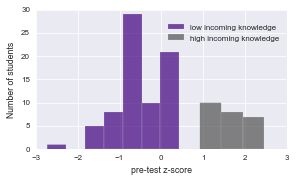

In [7]:
# df_scores.hist(column='z pre')
# print list(df_scores['z pre'])
sns.set_style("darkgrid")
sns.set_context("paper")
fig, ax = plt.subplots(1, figsize=(4.5,2.5))
sns.distplot(list([x for x in df_scores['z pre'] if x <= 0.45]), 
             bins=7, kde=False, rug=False, color='#3f007d', hist_kws={'alpha':0.7}, label = 'low incoming knowledge');
X = list([x for x in df_scores['z pre'] if x > 0.45])
X.extend([2.45,2.45,2.45])
sns.distplot(X,bins=3, kde=False, rug=False, color='#525252', hist_kws={'alpha':0.7},  label = 'high incoming knowledge');
ax.set_ylabel('Number of students')
ax.set_xlabel('pre-test z-score')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0,0.95))
fig.savefig('figs/hist_pre.svg')

#### Clearly, students' pre test is a bi modal distribution. Let's split them this way.

In [8]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [9]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


In [10]:
for x in ['high','low']:
    for y in ['scaff','not']:
        print x,y, len(set(df_scores[(df_scores['scaffolding']==y)&(df_scores['split pre']==x)]['student']))

high scaff 10
high not 12
low scaff 38
low not 36


In [11]:
for x in ['high','low']:
    for y in ['scaff','not']:
        print x,y, len(set(df_scores[(df_scores['scaffolding']==y)&(df_scores[df_scores['split pre']=='low']['split post t2']==x)]['student']))

high scaff 21
high not 17
low scaff 17
low not 19


In [12]:
a = set(get_students('split post t2','high'))
b = set(get_students('used this circuit sim before?',1))
c = set(get_students('split post t2','low'))
print len(a), len(b), len(a.intersection(b)), len(c.intersection(b))

57 37 20 17


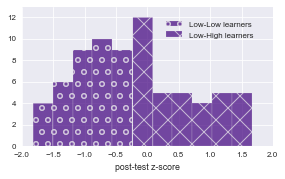

In [78]:
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
fig, ax = plt.subplots(1, figsize=(4.5,2.5))
sns.axes_style({'legend.numpoints': 20})
ax.set_ylim(0,13)
bar1 = sns.distplot(list([x for x in df_scores[df_scores['split pre']=='low']['z post t2'] if x <= median_learning2]), 
             bins=5, kde=False, rug=False, color='#3f007d', hist_kws={'alpha':0.7},  label = 'Low-Low learners');
bar2 = sns.distplot(list([x for x in df_scores[df_scores['split pre']=='low']['z post t2'] if x > median_learning2]), 
             bins=6, kde=False, rug=False, color='#3f007d', hist_kws={'alpha':0.7}, label = 'Low-High learners');
# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o','-', '+', 'x', '\\', '*', 'o']
# Loop over the bars
for i,thisbar in enumerate(bar1.patches):
    if i <=4:
    # Set a different hatch for each bar
        thisbar.set_hatch(hatches[5])
    else:
        thisbar.set_hatch(hatches[2])
ax.set_xlabel('post-test z-score')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(.95,0.95))
fig.savefig('figs/hist_post.svg')

(-0.010227478363913882, 0.93108127855166911)
SpearmanrResult(correlation=0.056539492731624882, pvalue=0.63231299992151602)


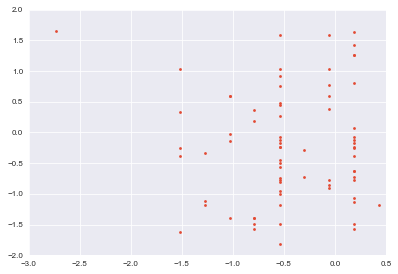

In [14]:
import scipy.stats as st
print st.pearsonr(df_scores[df_scores['split pre']=='low']["z pre"],df_scores[df_scores['split pre']=='low']["z post t2"] )
print st.spearmanr(df_scores[df_scores['split pre']=='low']["z pre"],df_scores[df_scores['split pre']=='low']["z post t2"] )
plt.plot(df_scores[df_scores['split pre']=='low']["z pre"],df_scores[df_scores['split pre']=='low']["z post t2"],'.')

### We can calculate the information gain of each sequence by time bin 
given a split by pre test

In [15]:
### if redoing this analysis, fix algorithm wot use frequency of use in each time bin because we have unequal groups

# students = get_students()
# CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
# shortest_seq_length = 2
# longest_seq_length = 10
# BINS = 4  #number of bins

# ### PARAMETERS
# attributes = [('split pre','high','low')]
# family_categories = ["Family","Family_tool","Family_default"]

# parse_axis = {0:'time',1:'group',None:'time and group'}
# pdf = PdfPages('infogain_results_by_pre.pdf')

# for attribute,level1,level2 in attributes:
#     for family_category in family_categories:
#         for axis in [0,1,None]:
#             if axis == 1: B = 1
#             else: B = BINS
        
#             print "For attribute {0}, category {1}".format(attribute,family_category)
#             pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
#             sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
#                                                           B,attribute,level1,level2,
#                                                           shortest_seq_length,longest_seq_length,CUT_OFF)
#             print len(sequence_counts)
#             ylabels = [level1,level2]
#             tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),5)
#             for seq,infogain in tops:
# #                 print seq, sequence_counts[seq]
#                 title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
#                 plot = plot_heat_map(sequence_counts[seq],title, ylabels)
#                 pdf.savefig( plot )
#                 plot.clf()
# pdf.close()

### We can calculate the information gain of each sequence by time bin 
given a split by post test, for only students that did poorly on pre test

For attribute split post t2, categories Family
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
time
CTcPTcP 0.3641088892
CTsPTs 0.376542673861
TbPC 0.392319968297
CTsPTsP 0.408294311177
PCTsP 0.445414830662
CTbP 0.48959483968
CTbPC 0.506922529124
TbCTb 0.761104577765
TbCP 0.878166070846
PTb 0.88163019901
PTbC 1.00388178622
TbCPC 1.01357327127
CTbCP 1.07255207679
TbCTbP 1.07807190511
CPTb 1.5861831497
For attribute split post t2, categories Family
Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
group
TcCTcCTc 0.0573168107445
CPCPCP 0.0706363739863
TsPTsP 0.0817041659455
CPTsP 0.0817041659455
CPCPCPC 0.0817041659455
CPTs 0.097606717205
TsCTsC 0.100256241302
TcCPC 0.109508359781
PCPCTcC 0.126018951873
PTsP 0.142851562572
CTsPTsP 0.147594

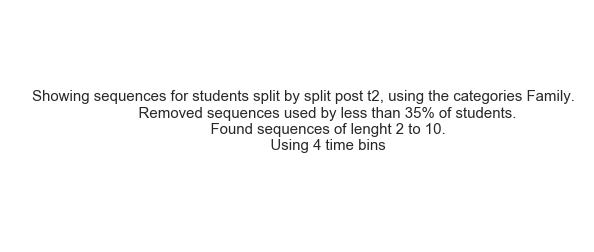

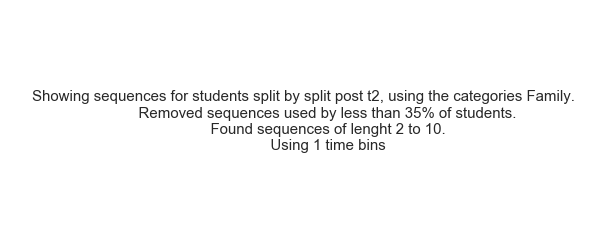

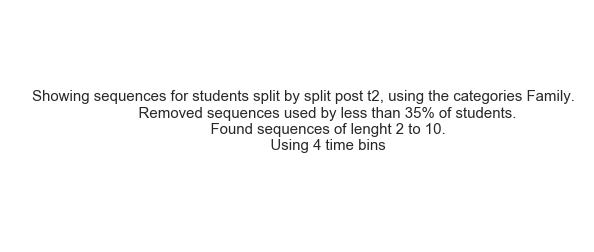

In [212]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 2
longest_seq_length = 10
BINS = 4  #number of bins

### PARAMETERS
attributes = [('split post t2','high','low')]
family_categories = ["Family"]#,"Family_tool","Family_default"]

parse_axis = {0:'time',1:'group',None:'time and group'}
pdf = PdfPages('infogain_results_by_post2.pdf')

for attribute,level1,level2 in attributes:
    for family_category in family_categories:
        for axis in [0,1,None]:
            if axis == 1: B = 1
            else: B = BINS
        
            print "For attribute {0}, categories {1}".format(attribute,family_category)
            pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
            sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)
            ylabels = [level1,level2]
            tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),15)
            print parse_axis[axis]
            for seq,infogain in tops:
                print seq, infogain
                title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
                plot = plot_heat_map(sequence_counts[seq],title, ylabels)
                pdf.savefig( plot )
                plot.clf()
pdf.close()

### We repeat the same analysis, only remove the first time bin before to see if what students do in other time bins differentiates them as well (though not as significantly).

In [ ]:
# parse_axis = {0:'time',1:'group',None:'time and group'}

# pdf = PdfPages('infogain_results_no_first_bin.pdf')

# for attribute,level1,level2 in attributes:
#     for family_category in family_categories:
#         for axis in [0,1,None]:
#             if axis == 1:
#                 B = 1
#             else:
#                 B = 3
        
#             print "For attribute {0}, categories {1}".format(attribute,family_category)
#             pdf.savefig(add_text(attribute,family_category,N, shortest_seq_length, longest_seq_length,B))
#             sequence_counts = get_sequence_use_by_timebin(df,students,family_category,B,attribute,level1,level2,shortest_seq_length,longest_seq_length,N)
#             sequence_counts = remove_first_bin(sequence_counts)
#             ylabels = [level1,level2]
#             tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),1)
#             for seq,infogain in tops:
#                 print seq, sequence_counts[seq]
#                 title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
#                 plot = plot_heat_map(sequence_counts[seq],title, ylabels)
#                 pdf.savefig( plot )
#                 plot.clf()
# pdf.close()

In [ ]:
# def remove_first_bin(sequence_counts):
#     new_seq_counts = {}
#     for s,c in sequence_counts.iteritems():
#         new_seq_counts[s] = c[:,1:]
#     return new_seq_counts  

In [18]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 35% of students
shortest_seq_length = 2
longest_seq_length = 10
B = 4  #number of bins

### PARAMETERS
attribute, level1, level2 = ('split post t2','high','low')
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)
print len(set(sequence_counts.keys()))

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
114


In [17]:
tops = get_top_seqs(rank_sequences(sequence_counts,1,1),10)
print tops
tops.sort(key=lambda tup: tup[1],reverse=True) 

[('CPTs', 0.097606717205021232), ('TsCTsC', 0.10025624130173738), ('TcCPC', 0.10950835978050866), ('PCPCTcC', 0.12601895187264223), ('PTsP', 0.14285156257162845), ('CTsPTsP', 0.14759482135052138), ('CPCTsC', 0.14759482135052138), ('TsPTsPC', 0.14759482135052138), ('PCTcCTcC', 0.14759482135052138), ('PTsPC', 0.17437347384210455)]


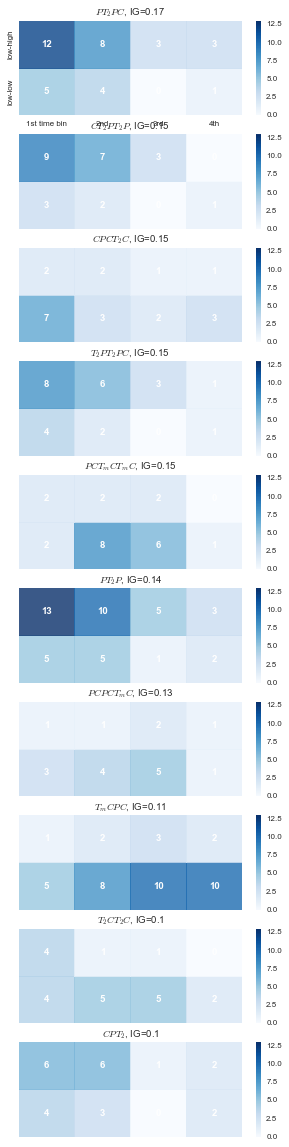

In [76]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(all_seqs),1)#, sharex=True, sharey=True)
maximum = max([np.amax(counts) for seq,counts in sequence_counts.iteritems() if seq in all_seqs])
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts[seq]
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.set_title(seq+', IG='+str(round(ig,2)))#,loc='left')

    if i ==0:
        cbar = True
    else:
        cbar = False

    # heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=True, annot=True, annot_kws={'fontweight':'bold','color':'white'})

    if i==0:
        xlabels = map(str, np.arange(data.shape[1])+1) 
        ylabels = ['low-low','low-high']
        xlabels = ['1st time bin','2nd','3rd','4th']
        ax.set_xticklabels([],)
        ax.set_yticks(np.arange(data.shape[0]) + 0.5)
        ax.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax.set_yticklabels(ylabels)
        ax.set_xticklabels(xlabels)
    else: 
        ax.set_xticklabels(['','','',''])
        ax.set_yticklabels(['',''])

    fig.set_size_inches(5,2*len(all_seqs))
    ax.set_frame_on(False)
#     ax.tick_params(
#         axis='both',        # changes apply to both the x and y-axis
#         which='both',       # both major and minor ticks are affected
#         bottom='off',       # ticks along the those edges are off
#         right='off', 
#         left='off',
#         top='off') 
fig.savefig('figs/heatmap_all.svg')

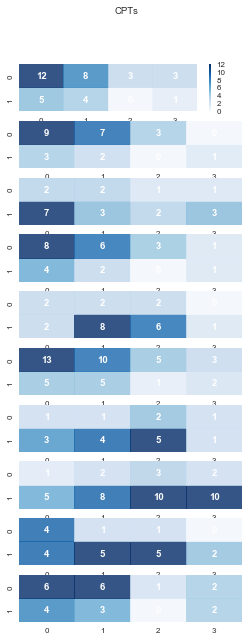

In [24]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig, axs = plt.subplots(len(tops),1)
#set title
for i,(seq,ig) in enumerate(tops):
    data = sequence_counts[seq]
    sns.plt.suptitle(seq)

    if i ==0:
        cbar = True
    else:
        cbar = False
    # heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)
    heatmap = sns.heatmap(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0, cbar=cbar, 
                          annot=True, annot_kws={'fontweight':'bold','color':'white'},
                         ax = axs[i])

    # put time labels on top
    ax.xaxis.tick_top()
    fig.set_size_inches(4, 1*len(tops))
    ax.set_frame_on(False)
    ax.tick_params(
        axis='off',        # changes apply to both the x and y-axis
        which='off',       # both major and minor ticks are affected
        bottom='off',       # ticks along the those edges are off
        right='off', 
        left='off',
        top='off') 
    if i==0:
        ax.tick_params(
            axis='both',        # changes apply to both the x and y-axis
            which='both',       # both major and minor ticks are affected
            bottom='off',       # ticks along the those edges are off
            right='off', 
            left='off',
            top='off') 
        # for y in range(data.shape[0]):
        #     for x in range(data.shape[1]):
        #         plt.text(x + 0.5, y + 0.5, '%.0f' % data[y, x],
        #                  horizontalalignment='center',
        #                  verticalalignment='center', fontsize = 23,
        #                  fontweight='bold', color='white'
        #                  )
        # put the major ticks at the middle of each cell
        ax.set_yticks(np.arange(data.shape[0]) + 0.5)
        ax.set_xticks(np.arange(data.shape[1]) + 0.5)

        # Set the labels
        xlabels = map(str, np.arange(data.shape[1])+1) 
        ylabels = ['low-high','low-low']
        ax.set_xticklabels([],)
        ax.set_yticklabels(ylabels)

fig.savefig('figs/heatmap.svg')